In [1]:
import os
import pyspark
import numpy as np
import pandas as pd
import itertools as it
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType

In [2]:
def get_data(query):
    """
    Returns the pySpark DataFrame
    
    Parameters:
        query (str): The input HQL query
        
    Returns:
        DataFrame (pySpark)
    """
    try:
        return sessn.sql(query)
    except Exception as e:
        print(e)

In [3]:
def get_eda(data, feature_list, feature_family=None):
    """
    
    Perform EDA on the provided dataset basis on its family i.e categorical or continuos

    Parameters:
        data: DataFrame (pySpark)
        feature_list (list)
        feature_family: continuous or categorical, default:None

    Returns:
        DataFrame (pySpark)
        
    """
    if feature_family == "continuos":
        from pyspark.sql.functions import isnan, when, count, col
        null_count_df = data.select(
            [count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in feature_list]).toPandas()
        null_count_df.index = ['MissingValue']
        describe_df = data.select(feature_list).describe().toPandas()
        describe_df = describe_df.set_index('summary')
        describe_df = describe_df.append(null_count_df) 
        describe_df = describe_df.reset_index()
        return describe_df
    if feature_family == "categorical":
        from pyspark.sql.functions import trim
        data_cat = data.select(feature_list)
        cat_null_count = []
        freq_dist = {}
        for col_ in data_cat.columns:
            print("Processing {}".format(col_))
            data_cat = data_cat.withColumn(col_, trim(data_cat[col_]))
            freq_dist_df = data_cat.groupby(col_).count().toPandas()
            count = data_cat.filter((data_cat[col_] == "")|(data_cat[col_].isNull())).count()
            cat_null_count.append((col_, count))
            freq_dist[col_] = freq_dist_df
        cat_null_count_df = pd.DataFrame(cat_null_count, columns=['Feature', 'MissingValue'])
        total_lines = data_cat.count()
        cat_null_count_df['%MissingValue'] = (cat_null_count_df['MissingValue'] / total_lines) * 100
        cat_null_count_df['%MissingValue'] = cat_null_count_df['%MissingValue'].round(2)
        return freq_dist, cat_null_count_df
    else:
        print("Only two values are possible: \n1. continuos \n2. categorical")

In [4]:
def bivariate_analysis(data, feature, group_feature, feature_family):
    """
    
    Bivariate Analysis of all feature to compute statistics. This include count, mean, standard deviation , min, max, quartiles,
    measures of skewness & kurtosis of the continuous signals w.r.t  servicing targeted group feature.
    Bivariate frequency distribution of the signals w.r.t  feature family.
    
    Parameters:
        data: DataFrame (pySpark)
        feature: String
        group_feature: String
        feature_family: continuous or categorical, default:None
        
    Returns:
        DataFrame (pySpark)
    
    """
    if feature_family == "continuos":
        result = data.groupby(group_feature).agg(F.count(feature).alias('count'), 
                                           F.mean(feature).alias('mean'), 
                                           F.stddev(feature).alias('std'), 
                                           F.min(feature).alias('min'), 
                                           F.expr('percentile({}, array(0.25))'.format(feature))[0].alias('%25'), 
                                           F.expr('percentile({}, array(0.5))'.format(feature))[0].alias('%50'), 
                                           F.expr('percentile({}, array(0.75))'.format(feature))[0].alias('%75'), 
                                           F.skewness(feature).alias('skewness'),
                                           F.kurtosis(feature).alias('kurtosis'),
                                           F.max(feature).alias('max'))
        return result
    if feature_family == "categorical":
        result = data.groupBy(group_feature).pivot(feature).agg(F.count("*"))
        result = result.withColumnRenamed("0", feature + "_0")
        result = result.withColumnRenamed("1", feature + "_1")
        return result
    else:
        print("Only two values are possible: \n1. continuos \n2. categorical")

In [5]:
def get_lookbck_data(modelling_data, base_data, lb_dur, entity, dt_col, grouping_entity):
    """
    
    Calculate the occurance probability of the entity of the provided lookback duration.

    Parameters:
        modelling_data: DataFrame (pySpark)
        base_data: DataFrame (pySpark)
        lb_dur: int
        entity: string
        dt_col: date object
        grouping_entity: string

    Returns:
        DataFrame (pySpark)
        
    """
    lst_dt_lb = dt_col + "_lst_dt_lb"
    lst_dt_m = dt_col + "_lst_dt_m"
    lb_col_list = [grouping_entity, entity]
    lb_col_list.append(dt_col)
    m_dt_data = modelling_data.select(dt_col).withColumn(lst_dt_m, F.last_day(dt_col))
    m_dt_data = m_dt_data.select(lst_dt_m).distinct()
    df_mnth_list = []
    for m in range(lb_dur):
        m2 = -1*(m+1)
        lb_m = "mnth_diff_"+str(m+1)
        df_mnth_list.append(lb_m)
        m_dt_data = m_dt_data.withColumn(lb_m, F.add_months(F.col(lst_dt_m), m2))
    m_dt_data = m_dt_data.withColumn("temp", F.array(df_mnth_list))
    m_dt_data = m_dt_data.withColumn(lst_dt_lb, F.explode("temp")).select(lst_dt_m, lst_dt_lb)
    lb_dt_data = base_data.select(lb_col_list)
    lb_dt_data = lb_dt_data.withColumn(lst_dt_lb, F.last_day(dt_col))
    lb_dt_data = lb_dt_data.drop(dt_col)
    lb_dt_data_freq = lb_dt_data.groupby(lb_dt_data.columns).count()
    md_data_freq = lb_dt_data_freq.join(m_dt_data, on = lst_dt_lb, how ="inner")
    md_data_freq = md_data_freq.groupby([grouping_entity, entity, lst_dt_m]).agg(F.sum("count").alias("freq"))
    md_data_freq_sum = md_data_freq.groupby([grouping_entity, lst_dt_m]).agg(F.sum("freq").alias("freq_sum"))
    md_data_freq_dist = md_data_freq.join(md_data_freq_sum, on = [grouping_entity, lst_dt_m], how = "inner")
    md_data_freq_dist = md_data_freq_dist.withColumn("freq_dist", F.round(F.col("freq")/F.col("freq_sum"), 3))
    lb_data = md_data_freq_dist.select(grouping_entity, lst_dt_m, entity, "freq_dist")
    lb_data = lb_data.withColumnRenamed(lst_dt_m , dt_col)
    return lb_data

In [40]:
def ind_clm_aggrtion(data, c):
    c_sum = c + "_sum"
    data = data.groupby(group_level).agg(F.sum(c).alias(c_sum))
    data = data.withColumn(c, F.when(F.col(c_sum)>0, F.lit(1)).otherwise(F.lit(0)))
    data = data.drop(c_sum)
    return data

In [83]:
# Configuration
home_path = "/mapr/datalake/uhc/ei/pi_ara/sherlock/development/HPP-Provider-Signature-Monitoring/"
# Input Table 
preprocessed_table = "pi_usrs.hpp_ps_data_processed"
# Output Table
feature_engineered_table = "pi_usrs.hpp_ps_signal_data"

In [7]:
try:
    os.mkdir(home_path)
except:
    print("Directory Exist")
os.chdir(home_path)

Directory Exist


In [8]:
try:
    sc.stop()
except Exception as e:
    print(e)
try:
    sessn.stop()
except Exception as e:
    print(e)
try:
    sc.SparkContext.stop()
except Exception as e:
    print(e)

name 'sessn' is not defined
'SparkContext' object has no attribute 'SparkContext'


In [9]:
conf = pyspark.SparkConf().setAll([('spark.executor.memory', '8g'), 
                                   ('spark.executor.instances', '15'),
                                   ('spark.executor.cores', '4'), 
                                   ('spark.driver.cores','4'), 
                                   ('spark.driver.memory','12g'),
                                   ('spark.yarn.queue', 'araadh_q1.arapi_sq1'),
                                   ('spark.yarn.executor.memoryOverhead', '2g')])
sessn = SparkSession.builder.appName("HPP").config(conf=conf).enableHiveSupport().getOrCreate().newSession()
sessn

### Data Acquisition & Preparation

In [85]:
base_data = sessn.table(preprocessed_table)

In [86]:
base_data.select(F.min("batch_run_dt"), F.max("batch_run_dt")).show()

+-----------------+-----------------+
|min(batch_run_dt)|max(batch_run_dt)|
+-----------------+-----------------+
|       2018-12-01|       2020-01-31|
+-----------------+-----------------+



##### Filtering out the lookback data

In [87]:
modelling_data = base_data.filter(F.col("batch_run_dt")>="2019-03-01")

In [88]:
modelling_data.select(F.max("batch_run_dt"), F.min("batch_run_dt")).show()
base_data_clmc = modelling_data.select("srk_clm_id_rj").distinct().count()
print("{} claim present in data".format(base_data_clmc))
base_data_lc = modelling_data.count()
print("{} claim lines present in data".format(base_data_lc))

+-----------------+-----------------+
|max(batch_run_dt)|min(batch_run_dt)|
+-----------------+-----------------+
|       2020-01-31|       2019-03-01|
+-----------------+-----------------+

1164010 claim present in data
2981148 claim lines present in data


### Feature Engineering - Signal Generatiom (Claim Level)

In [89]:
group_level = ['servicing_npi', 'srk_clm_id_rj']

In [63]:
base_df = modelling_data.groupby(group_level).count()

#### 1. Billed Amount

In [64]:
c = "billed_amt_sum"
billed_amt_sum_data = modelling_data.groupby(group_level).agg(F.sum("cl_line_item_chrg_amt").alias(c))
output_df = base_df.join(billed_amt_sum_data, on = group_level, how ="left")

#### 2. Number of claim lines

In [65]:
c = "clm_ln_cnt"
clm_ln_cnt_data = modelling_data.groupby(group_level).agg(F.count("*").alias(c))
output_df = output_df.join(clm_ln_cnt_data, on = group_level, how ="left")

#### 3. Sum of Unit Billed

In [66]:
c = "clm_unit_billed"
clm_unit_billed_data = modelling_data.groupby(group_level).agg(F.sum("cl_units_billed").alias(c))
output_df = output_df.join(clm_unit_billed_data, on = group_level, how ="left")

#### 4. EM proc indicator 

In [67]:
c = "em_proc_ind"
em_proc_code_list = [99204, 99205, 99214, 99215, 99222, 99223, 99232, 99233]
em_proc_code_list = [str(i) for i in em_proc_code_list]
em_proc_code_pd = pd.DataFrame(em_proc_code_list, columns = ['cl_proc_cd'])
em_proc_code = sessn.createDataFrame(em_proc_code_pd)
em_proc_code = em_proc_code.withColumn(c, F.lit(1))
em_proc_ind_data = modelling_data.join(em_proc_code, on ="cl_proc_cd", how="left")
em_proc_ind_data = em_proc_ind_data.fillna(0, subset=[c])
em_proc_ind_data = em_proc_ind_data.select(group_level + [c])
em_proc_ind_clm_data = ind_clm_aggrtion(em_proc_ind_data, c)
output_df = output_df.join(em_proc_ind_clm_data, on = group_level, how ="left")

#### 5.  high cost proc indicator 

In [68]:
c = "high_cst_proc_ind"
high_cost_j_code_list = ["J9355", "J1459", "J0885", "J0135", "J0570", "J0584", "J1602", "J9999"]
high_cost_j_code_pd = pd.DataFrame(high_cost_j_code_list, columns = ['cl_proc_cd']).drop_duplicates()
high_cost_j_code = sessn.createDataFrame(high_cost_j_code_pd)
high_cost_j_code = high_cost_j_code.withColumn(c, F.lit(1))
high_cst_proc_ind_data = modelling_data.join(high_cost_j_code, on ="cl_proc_cd", how="left")
high_cst_proc_ind_data = high_cst_proc_ind_data.fillna(0, subset=[c])
high_cst_proc_ind_data = high_cst_proc_ind_data.select(group_level + [c])
high_cst_proc_ind_clm_data = ind_clm_aggrtion(high_cst_proc_ind_data, c)
output_df = output_df.join(high_cst_proc_ind_clm_data, on = group_level, how ="left")

#### 6. Emergency indicator 

In [69]:
c = "emgncy_ind"
col_ = ["cl_emergency_ind", "cl_place_of_srcv"]
emrgncy_ind_data = modelling_data.select(group_level + col_)
emrgncy_ind_data = emrgncy_ind_data.withColumn(c, F.when(((F.col("cl_place_of_srcv")=="23")&(F.col("cl_emergency_ind")==0)),
                                                         F.lit(1)).otherwise(F.lit(0)))
emrgncy_ind_clm_data = ind_clm_aggrtion(emrgncy_ind_data, c)
output_df = output_df.join(emrgncy_ind_clm_data, on = group_level, how ="left")

##### Preparing data for Modifier signal

In [70]:
def get_mod_data(data, level, mod_col):
    data_mod = data.select(level + mod_col)
    data_mod = data_mod.withColumn("cl_proc_mod_list", F.array(mod_col)).select(level + ["cl_proc_mod_list"])
    data_mod =  data_mod.withColumn("cl_proc_mod", F.explode("cl_proc_mod_list")).select(level + ["cl_proc_mod"])
    return data_mod

In [71]:
mod_col = [c[0] for c in modelling_data.dtypes if "mod" in c[0]]
data_mod = get_mod_data(modelling_data, group_level, mod_col)

#### 7. Modifier 59 indicator 

In [72]:
c = "mod59_ind"
data_mod_dummy = data_mod.select("servicing_npi", "srk_clm_id_rj", "cl_proc_mod")
data_mod_dummy = data_mod_dummy.withColumn(c, F.when(F.col("cl_proc_mod")=="59", F.lit(1)).otherwise(F.lit(0)))
mod59_ind_clm_data = ind_clm_aggrtion(data_mod_dummy, c)
output_df = output_df.join(mod59_ind_clm_data, on = group_level, how ="left")

#### 8. Modifier 91 indicator

In [73]:
c = "mod91_ind"
c_sum = c + "_sum"
data_mod_dummy = data_mod.select("servicing_npi", "srk_clm_id_rj", "cl_proc_mod")
data_mod_dummy = data_mod_dummy.withColumn(c, F.when(F.col("cl_proc_mod")=="91", F.lit(1)).otherwise(F.lit(0)))
mod91_ind_clm_data = ind_clm_aggrtion(data_mod_dummy, c)
output_df = output_df.join(mod91_ind_clm_data, on = group_level, how ="left")

#### 9. Modifier TC indicator - TW

In [74]:
c = "modTC_ind"
c_sum = c + "_sum"
data_mod_dummy = data_mod.select("servicing_npi", "srk_clm_id_rj", "cl_proc_mod")
data_mod_dummy = data_mod_dummy.withColumn(c, F.when(F.col("cl_proc_mod")=="TC", F.lit(1)).otherwise(F.lit(0)))
modTC_ind_clm_data = ind_clm_aggrtion(data_mod_dummy, c)
output_df = output_df.join(modTC_ind_clm_data, on = group_level, how ="left")

#### LookBack Features

#### 10. Unsual procedure code

In [75]:
c = "proc_code_unusual"
lb_dur = 3
dt_col = "batch_run_dt"
entity = "cl_proc_cd"
grouping_entity = "servicing_npi"
lb_group_level = [grouping_entity, entity, dt_col]
# Generating Lookback lookup table
proc_code_lb_data = get_lookbck_data(modelling_data, base_data, lb_dur, entity, dt_col, grouping_entity)
# Merging the data 
modelling_data_lb = modelling_data.select(lb_group_level + ['srk_clm_id_rj'])
modelling_data_lb = modelling_data_lb.withColumn("batch_run_dt", F.last_day("batch_run_dt"))
proc_code_unusual_data = modelling_data_lb.join(proc_code_lb_data, on = lb_group_level, how = "left")
# Aggregating the result at claim level
proc_code_unusual_data = proc_code_unusual_data.groupby(group_level).agg(F.min("freq_dist").alias(c))
proc_code_unusual_data = proc_code_unusual_data.fillna({c:0})
output_df = output_df.join(proc_code_unusual_data, on = group_level, how ="left")

#### 11. Unusal place of service

In [76]:
c = "pos_unsual"
lb_dur = 3
dt_col = "batch_run_dt"
entity = "cl_place_of_srcv"
grouping_entity = "servicing_npi"
lb_group_level = [grouping_entity, entity, dt_col]
# Generating Lookback lookup table
pos_lb_data = get_lookbck_data(modelling_data, base_data, lb_dur, entity, dt_col, grouping_entity)
# Merging the data 
modelling_data_lb = modelling_data.select(lb_group_level + ['srk_clm_id_rj'])
modelling_data_lb = modelling_data_lb.withColumn("batch_run_dt", F.last_day("batch_run_dt"))
pos_unusual_data = modelling_data_lb.join(pos_lb_data, on = lb_group_level, how = "left")
# Aggregating the result at claim level
pos_unusual_data = pos_unusual_data.groupby(group_level).agg(F.min("freq_dist").alias(c))
pos_unusual_data = pos_unusual_data.fillna({c:0})
output_df = output_df.join(pos_unusual_data, on = group_level, how ="left")

#### Saving the output

In [77]:
col_to_save = ['servicing_npi',
             'srk_clm_id_rj',
             'billed_amt_sum',
             'clm_ln_cnt',
             'clm_unit_billed',
             'em_proc_ind',
             'high_cst_proc_ind',
             'emgncy_ind',
             'mod59_ind',
             'mod91_ind',
             'modTC_ind',
             'proc_code_unusual',
             'pos_unsual']

In [78]:
output_df.select(col_to_save).write.mode("overwrite").saveAsTable(feature_engineered_table)

#### Sanity Check

In [90]:
query = "select * from " + feature_engineered_table
output_df = get_data(query)

In [91]:
output_df_lc = output_df.count()
print("{} claim lines present in processed data".format(output_df_lc))

1164033 claim lines present in processed data


In [92]:
continuos_var = [c[0] for c in output_df.dtypes if (c[1]=='double') | (c[1]=='int') | (c[1]=='bigint')]
categorical_var = [c[0] for c in output_df.dtypes if ((c[1]=='string')& ('id' not in c[0]))]

In [93]:
eda_continuos = get_eda(output_df, continuos_var, "continuos")
eda_continuos

index      billed_amt_sum          clm_ln_cnt     clm_unit_billed  \
0         count             1164033             1164033             1164033   
1          mean  232.49352774362336   2.561051104221272   8.365363043831232   
2        stddev   9240.269506550085  2.7624783156908475  3090.8663283130295   
3           min                 0.0                   1                 0.0   
4           max           9950155.0                  47           1923691.0   
5  MissingValue                   0                   0                   0   

           em_proc_ind     high_cst_proc_ind             emgncy_ind  \
0              1164033               1164033                1164033   
1   0.3667481935649591  8.590821737871693E-7  1.8899807823317724E-4   
2  0.48191716673989976  9.268668587165961E-4   0.013746363893551414   
3                    0                     0                      0   
4                    1                     1                      1   
5                    0                     0                      0   

             mod59_ind             mod91_ind              modTC_ind  \
0              1164033               1164033                1164033   
1  0.04895651583760941  4.802269351470276E-4  0.0022920312396641678   
2  0.21577723557724704  0.021908827663625004    0.04782028645870216   
3                    0                     0                      0   
4                    1                     1                      1   
5                    0                     0                      0   

     proc_code_unusual          pos_unsual  
0              1164033             1164033  
1  0.11800985453161623  0.9158819483640008  
2  0.14971931933605026    0.21681960177738  
3                  0.0                 0.0  
4                  1.0                 1.0  
5                    0                   0

### EDA 

#### Bivariate Analysis

In [94]:
col_to_work = [c for c in output_df.columns if "ind" not in c]
group_level = ['servicing_npi', 'srk_clm_id_rj']
continuos_cols = list(set(col_to_work)-set(group_level))
binary_cols = [c for c in output_df.columns if "ind" in c]

In [95]:
eda_result_continuos = {}
for s in continuos_cols:
    result = bivariate_analysis(output_df, s, "servicing_npi", "continuos")
    eda_result_continuos[s] = result

In [96]:
r_billed_amt_sum = eda_result_continuos['billed_amt_sum'].toPandas()

In [97]:
r_billed_amt_sum.head(10)

servicing_npi  count         mean          std     min     %25     %50  \
0    1003866393   2121   232.701306   196.690460    5.00  117.00  173.00   
1    1003982059    851   155.238696   112.591310   21.33  100.00  146.00   
2    1093034399    276   321.851449   224.355634  105.00  198.00  253.00   
3    1093702961    274   158.415109    52.432808   65.00  122.98  124.13   
4    1811995723   1552   193.562094   259.459196   10.00  135.00  185.00   
5    1972748580    107   226.259439    87.075652   95.00  149.00  250.00   
6    1831176346     14  1355.571429  1319.735246  145.00  222.60  406.50   
7    1013338961     14   108.000000    16.176907   75.00  109.00  109.00   
8    1760572754      6   287.666667   327.848542   60.00  113.00  140.00   
9    1215011663     15   292.266667   154.283351  140.00  153.50  220.00   

       %75   skewness    kurtosis      max  
0   272.00   1.506202    1.551766   991.00  
1   148.00   3.148919   10.488127   750.05  
2   340.00   3.267193   14.985594  1997.00  
3   208.83   0.942025    0.626091   364.07  
4   210.00  23.294045  608.124527  7000.00  
5   250.00   1.351421    3.955945   628.00  
6  2821.60   0.278774   -1.909401  2821.60  
7   109.75   0.490572    2.537186   150.00  
8   304.25   1.445245    0.483988   923.00  
9   405.00   0.589680   -1.178775   539.00

In [98]:
eda_result_binary = {}
for s in binary_cols:
    result = bivariate_analysis(output_df, s, "servicing_npi", "categorical")
    eda_result_binary[s] = result

In [99]:
mod91_ind_r = eda_result_binary['mod91_ind'].toPandas()
mod91_ind_r.head(10)

servicing_npi  mod91_ind_0  mod91_ind_1
0    1811995723         1552          NaN
1    1215011663           15          NaN
2    1003982059          851          NaN
3    1831176346           14          NaN
4    1518002237            3          NaN
5    1831249051            4          NaN
6    1093034399          276          NaN
7    1003866393         2121          NaN
8    1972748580          107          NaN
9    1770062960            8          NaN

##### Correlation matrix

In [100]:
corr_cols = list(set(output_df.columns) - set(group_level))
col_combination = list(it.product(corr_cols, repeat = 2 ))
out_list = []
for c in col_combination:
    r = output_df.corr(c[0], c[1])
    out_list.append((c[0], c[1], r))
corr_tab = pd.DataFrame(out_list)

In [102]:
corr_df = corr_tab.pivot(index=0, columns=1, values=2)

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

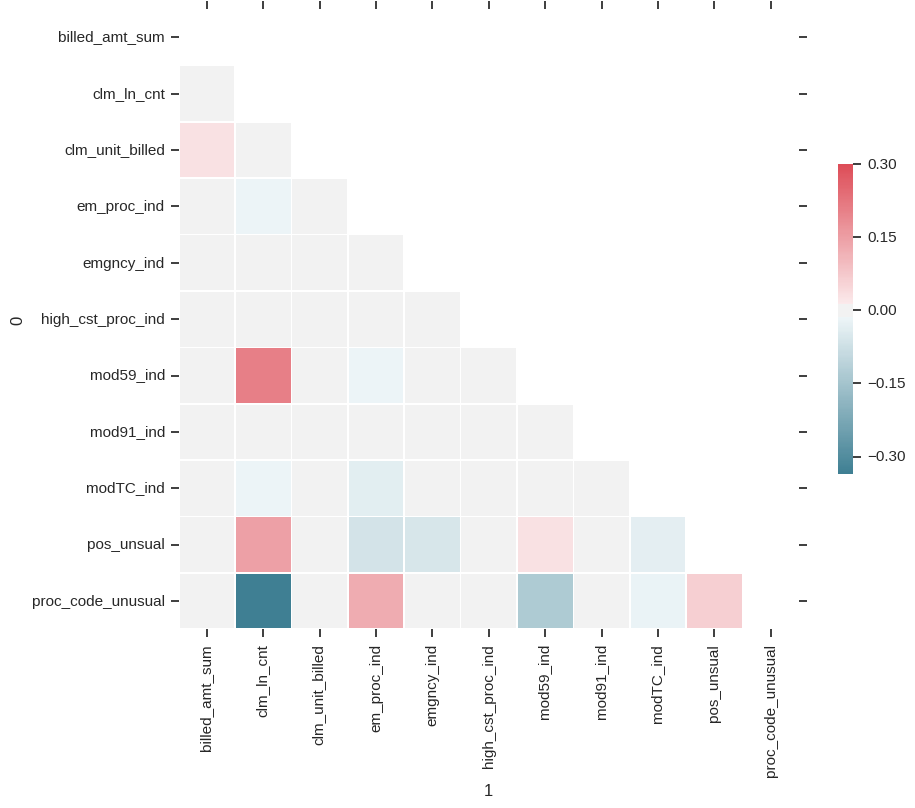

In [113]:
sns.set(style="white")
# Generating HeatMap
mask = np.triu(np.ones_like(corr_df, dtype=np.bool))
f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})